<a href="https://colab.research.google.com/github/sridharsakkari/Demand-Forecasting/blob/master/Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/sridharsakkari/Demand-Forecasting.git

Cloning into 'Demand-Forecasting'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 8), reused 9 (delta 4), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import plotly.graph_objects as go

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Step 1:

#Problem Statement : 

One of the largest retail chains in the world wants to use their vast data source to build an efficient forecasting model to predict the sales for each SKU in its portfolio at its 76 different stores using historical sales data for the past 3 years on a week-on-week basis. 

The goal of this project is to accurately forecast the weekly sales of every product at every store for next 12 weeks.

#Step 2 : 

Import the training and test data 

In [3]:
train_data = pd.read_csv('/content/Demand-Forecasting/train_data_sales.csv')
test_data = pd.read_csv('/content/Demand-Forecasting/test_data_sales.csv')

train_data_raw = train_data.copy()
test_data_raw = test_data.copy()

In [4]:
train_data.shape

(150150, 9)

In [5]:
train_data.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [6]:
#.set_index('record_ID',inplace = True,drop =True)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


In [8]:
train_data['store_id'] = train_data['store_id'].astype('str')
train_data['sku_id'] = train_data['sku_id'].astype('str')

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  object 
 3   sku_id           150150 non-null  object 
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 10.3+ MB


In [10]:
train_data['week'] = pd.to_datetime(train_data['week'],dayfirst=True)

In [11]:
train_data.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52


# Details of Each column: 

1. record_ID : Unique Id for each store and sku combination. 

2. week : Starting date of every week

3. store_id : Unique ID for every store

4. sku_id : Unique ID for every product

5. total_price : sales price of every product

6. base_price : base price

7. is_featured_sku : is it the featured item of week

8. is_display_sku : is the product on the display at a prominent place

9. units_sold : total units sold at the store

In [12]:
train_data['year'] = train_data['week'].dt.year
train_data['month'] = train_data['week'].dt.month
train_data['week_num'] = train_data['week'].dt.week

In [13]:
# check for na values

train_data.isna().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
year               0
month              0
week_num           0
dtype: int64

In [14]:
# one value of total_price is na. So that value can either be replaced or removed. In this case, the na values will be removed

train_data.fillna(0,inplace = True)

In [15]:
train_data.isna().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
year               0
month              0
week_num           0
dtype: int64

# Step 3: Exploratory Data Analysis 

## Univariate Analysis

In [16]:
units_sold_weekly_tot = train_data.groupby(['week'])['units_sold'].aggregate(np.sum).reset_index().sort_values('week')
units_sold_weekly_tot['year'] = units_sold_weekly_tot['week'].dt.year
units_sold_weekly_tot['week_num'] = units_sold_weekly_tot['week'].dt.week



In [17]:
import plotly.express as px
plt.rcParams['figure.figsize'] = (20,10)
px.bar(units_sold_weekly_tot,x= 'week', y='units_sold',color = 'week_num')


In [18]:
#extracting mean sales w.r.t store_id and item_ids

units_sold_mean_store = train_data.groupby(['week','store_id'])[['units_sold']].aggregate(np.sum).reset_index().sort_values('units_sold',ascending = False)
units_sold_mean_items = train_data.groupby(['week','sku_id'])[['units_sold']].aggregate(np.sum).reset_index().sort_values('units_sold',ascending = False)

units_sold_mean_store['year'] = units_sold_mean_store['week'].dt.year
units_sold_mean_store['week_num'] = units_sold_mean_store['week'].dt.week

units_sold_mean_items['year'] = units_sold_mean_items['week'].dt.year
units_sold_mean_items['week_num'] = units_sold_mean_items['week'].dt.week



In [19]:
px.scatter_3d(z = 'week_num', y = 'units_sold',x = 'store_id',data_frame = units_sold_mean_store,color = 'store_id',size= 'units_sold')

In [20]:
total_price_mean_store = train_data.groupby(['week','store_id'])['total_price'].aggregate(np.mean).reset_index().sort_values('total_price',ascending = False)
base_price_mean_store = train_data.groupby(['week','store_id'])['base_price'].aggregate(np.mean).reset_index().sort_values('base_price',ascending = False)

total_price_mean_items = train_data.groupby(['week','sku_id'])['total_price'].aggregate(np.mean).reset_index().sort_values('total_price',ascending = False)
base_price_mean_items = train_data.groupby(['week','sku_id'])['base_price'].aggregate(np.mean).reset_index().sort_values('base_price',ascending = False)

In [21]:
units_sold_mean_store.head()

,week,store_id,units_sold,year,week_num
369,2011-02-14,9845,4691,2011,7
5309,2012-05-15,9845,3660,2012,20
367,2011-02-14,9823,3544,2011,7
304,2011-02-14,8023,3512,2011,7
5233,2012-05-08,9845,3487,2012,19


In [22]:
units_sold_weekly = train_data.groupby(['week_num'])['units_sold'].aggregate(np.mean).reset_index().sort_values('week_num')
base_price_weekly = train_data.groupby(['week_num'])['base_price'].aggregate(np.mean).reset_index().sort_values('base_price')
total_price_weekly = train_data.groupby(['week_num'])['total_price'].aggregate(np.mean).reset_index().sort_values('total_price')

weekly_data_1 = pd.merge(units_sold_weekly,base_price_weekly,how='inner')
weekly_data = pd.merge(weekly_data_1,total_price_weekly,how = 'inner')
weekly_data['discounts'] = weekly_data['base_price'] - weekly_data['total_price']

In [23]:
plt.rcParams['figure.figsize'] = (30,30)
#px.scatter_3d(data_frame = weekly_data,x = 'units_sold',y='base_price',z='total_price',color = 'week_num',size = 'units_sold')
px.scatter(data_frame = weekly_data, x = 'units_sold', y = 'discounts', color = 'week_num',size = 'units_sold')

In [24]:
store_units_sold = units_sold_mean_store.groupby(['store_id'])['units_sold'].aggregate(np.mean).reset_index().sort_values('units_sold',ascending = False)
items_units_sold = units_sold_mean_items.groupby(['sku_id'])['units_sold'].aggregate(np.mean).reset_index().sort_values('units_sold',ascending = False)

In [25]:
store_ids = train_data['store_id'].unique()

df1 = train_data[['sku_id','units_sold']][train_data['store_id'] == store_ids[0]].groupby('sku_id').aggregate(np.mean)
for i in range(1,len(store_ids)):
  
  df2 = train_data[['sku_id','units_sold']][train_data['store_id'] == store_ids[i]].groupby('sku_id').aggregate(np.mean)
  df1 = pd.concat((df1,df2),axis=1,join = 'outer',sort = False)

data_store_items = df1
data_store_items.columns = store_ids
data_store_items = data_store_items.reset_index()

In [26]:
data_store_items.head()

,index,8091,8095,8094,8063,8023,8058,8222,8121,8218,8317,8319,8392,8398,8400,8422,8438,8555,8562,8869,8991,8911,9001,9043,9092,9112,9132,9147,9164,9178,9190,9221,9250,9273,9279,9281,9328,9371,9442,9430,9439,9425,9432,9436,9456,9479,9481,9490,9498,9532,9578,9672,9611,9613,9632,9680,9700,9713,9731,9745,9770,9789,9813,9823,9837,9809,9845,9872,9876,9879,9880,9881,9890,9909,9954,9961,9984
0,216233,29.107692,92.723077,55.946154,32.246154,121.607692,44.761538,95.253846,35.623077,26.323077,59.861538,37.584615,32.115385,59.023077,38.576923,27.138462,51.246154,26.246154,46.746154,68.061538,41.707692,27.684615,NaN,36.969231,25.484615,83.353846,31.707692,51.923077,44.584615,16.738462,74.692308,49.023077,68.215385,45.369231,32.515385,57.700000,34.715385,29.961538,39.992308,43.907692,26.600000,NaN,29.923077,40.753846,29.284615,31.369231,73.923077,32.553846,57.507692,54.446154,33.192308,49.161538,63.015385,77.853846,38.376923,21.500000,12.053846,40.738462,38.576923,54.692308,30.792308,16.600000,46.253846,105.415385,45.930769,44.330769,105.353846,36.330769,33.069231,35.200000,49.392308,59.407692,47.276923,60.792308,28.815385,63.423077,34.423077
1,216418,26.376923,167.007692,88.230769,47.246154,248.376923,98.453846,174.107692,50.246154,45.707692,NaN,NaN,NaN,104.569231,58.646154,41.869231,84.938462,27.330769,148.192308,124.692308,86.807692,49.684615,NaN,85.038462,66.607692,205.284615,NaN,97.469231,121.523077,NaN,NaN,38.338462,204.184615,241.638462,72.107692,41.153846,75.084615,70.538462,68.192308,75.276923,21.261538,49.661538,46.792308,30.761538,43.307692,83.869231,153.861538,56.361538,29.307692,58.546154,60.153846,90.123077,203.992308,241.800000,28.738462,38.153846,10.376923,129.046154,73.823077,154.038462,32.553846,43.100000,26.838462,160.807692,62.307692,94.461538,220.307692,92.300000,28.130769,45.746154,70.592308,148.846154,82.907692,51.938462,NaN,131.576923,15.507692
2,216419,28.307692,97.830769,96.769231,39.584615,222.830769,85.238462,104.669231,NaN,37.215385,54.307692,NaN,NaN,71.576923,59.992308,37.369231,81.176923,25.984615,102.853846,94.984615,87.161538,34.846154,8.423077,53.769231,45.807692,178.200000,15.023077,81.492308,98.023077,NaN,51.161538,NaN,144.107692,46.669231,71.576923,46.284615,65.561538,48.830769,45.400000,53.415385,31.030769,41.500000,50.423077,NaN,35.130769,88.184615,132.738462,50.715385,26.469231,64.569231,58.023077,70.938462,138.300000,197.461538,24.876923,40.476923,NaN,105.761538,40.361538,103.169231,NaN,46.553846,23.253846,103.238462,49.538462,85.423077,169.961538,77.992308,NaN,59.823077,72.069231,113.100000,68.053846,46.192308,48.961538,100.923077,54.576923
3,216425,25.669231,77.200000,26.746154,NaN,85.015385,39.369231,80.807692,19.323077,10.546154,20.523077,15.407692,16.323077,45.969231,37.715385,NaN,25.892308,NaN,46.315385,61.138462,23.553846,14.853846,NaN,31.092308,11.353846,63.292308,12.815385,55.376923,36.976923,NaN,28.453846,18.500000,57.415385,13.184615,19.392308,21.200000,18.538462,27.876923,27.838462,31.538462,13.084615,9.615385,18.607692,NaN,11.738462,20.769231,67.007692,14.038462,29.253846,26.707692,23.592308,40.969231,57.823077,72.961538,15.361538,13.530769,NaN,37.376923,35.792308,38.069231,NaN,NaN,20.415385,69.484615,41.592308,36.884615,91.292308,20.792308,NaN,19.900000,26.330769,46.969231,47.038462,41.153846,13.161538,58.569231,18.169231
4,217390,29.469231,141.584615,45.569231,30.953846,233.776923,84.807692,141.423077,28.730769,21.792308,49.646154,22.046154,20.607692,101.961538,39.469231,23.069231,47.892308,22.346154,104.407692,135.015385,46.700000,24.546154,NaN,68.330769,27.784615,124.169231,NaN,93.453846,90.069231,NaN,44.061538,38.284615,128.146154,23.061538,33.692308,29.861538,32.630769,61.453846,58.276923,61.853846,NaN,15.100000,30.376923,24.392308,16.253846,40.323077,124.838462,28.784615,31.815385,52.661538,56.461538,78.161538,121.584615,145.915385,26.200000,15.861538,NaN,77.623077,NaN,96.723077,17.146154,20.392308,27.107692,156.846154,68.361538,73.738462,150.976923,41.676923,20.146154,28.138462,4

In [27]:
val = data_store_items.values[:,1:].T.reshape(-1,1)
idx = []
idx_0 = list(data_store_items['index'])
for i in range(len(idx_0)):
  idx = idx + idx_0

data_store_items_reshape = pd.concat((pd.DataFrame(idx),pd.DataFrame(val)),axis = 1)
data_store_items_reshape.columns = ['item_id','units_sold']
data_store_items_reshape['store_idx'] = pd.DataFrame(np.repeat(store_ids,len(idx_0)))



In [28]:
plt.rcParams['figure.figsize'] = (10,10)
df = data_store_items_reshape.fillna(0)
#sns.stripplot(x = 'store_idx',y = 'units_sold',hue ='item_id',data = data_store_items_reshape,size= 15)
px.scatter_3d(data_frame= df,x = 'item_id',y='store_idx',z ='units_sold',color = 'store_idx',labels = None,size = 'units_sold')

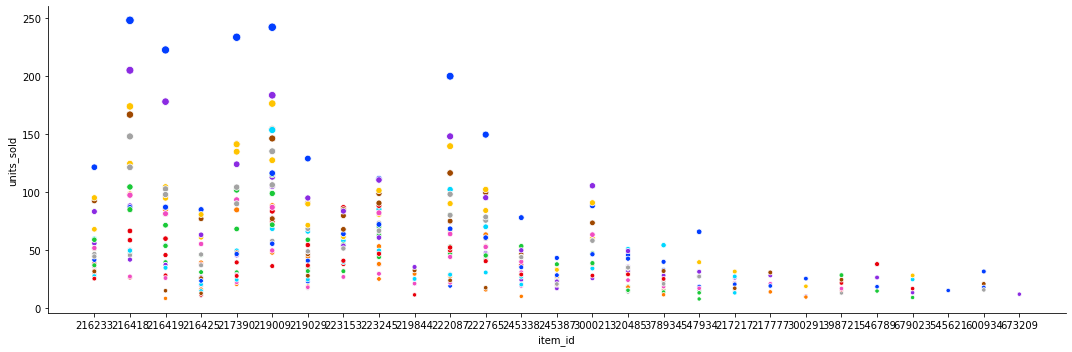

In [29]:
import plotly.graph_objects as go
plt.rcParams['figure.figsize'] = (20,10)
#sns.scatterplot(x = 'store_idx',y = 'units_sold',hue = 'item_id',data = data_store_items_reshape )
sns.relplot(x = 'item_id',y = 'units_sold',hue = 'store_idx',data = data_store_items_reshape, height=5, aspect = 3,size = 'units_sold',palette= 'bright',legend = False)

In [30]:
df_ = data_store_items_reshape.dropna(axis = 0)
df_['units_sold'] = pd.to_numeric(df_['units_sold'])
px.scatter(data_frame = df_,x = 'store_idx',y = 'units_sold', color = 'item_id',size = 'units_sold')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



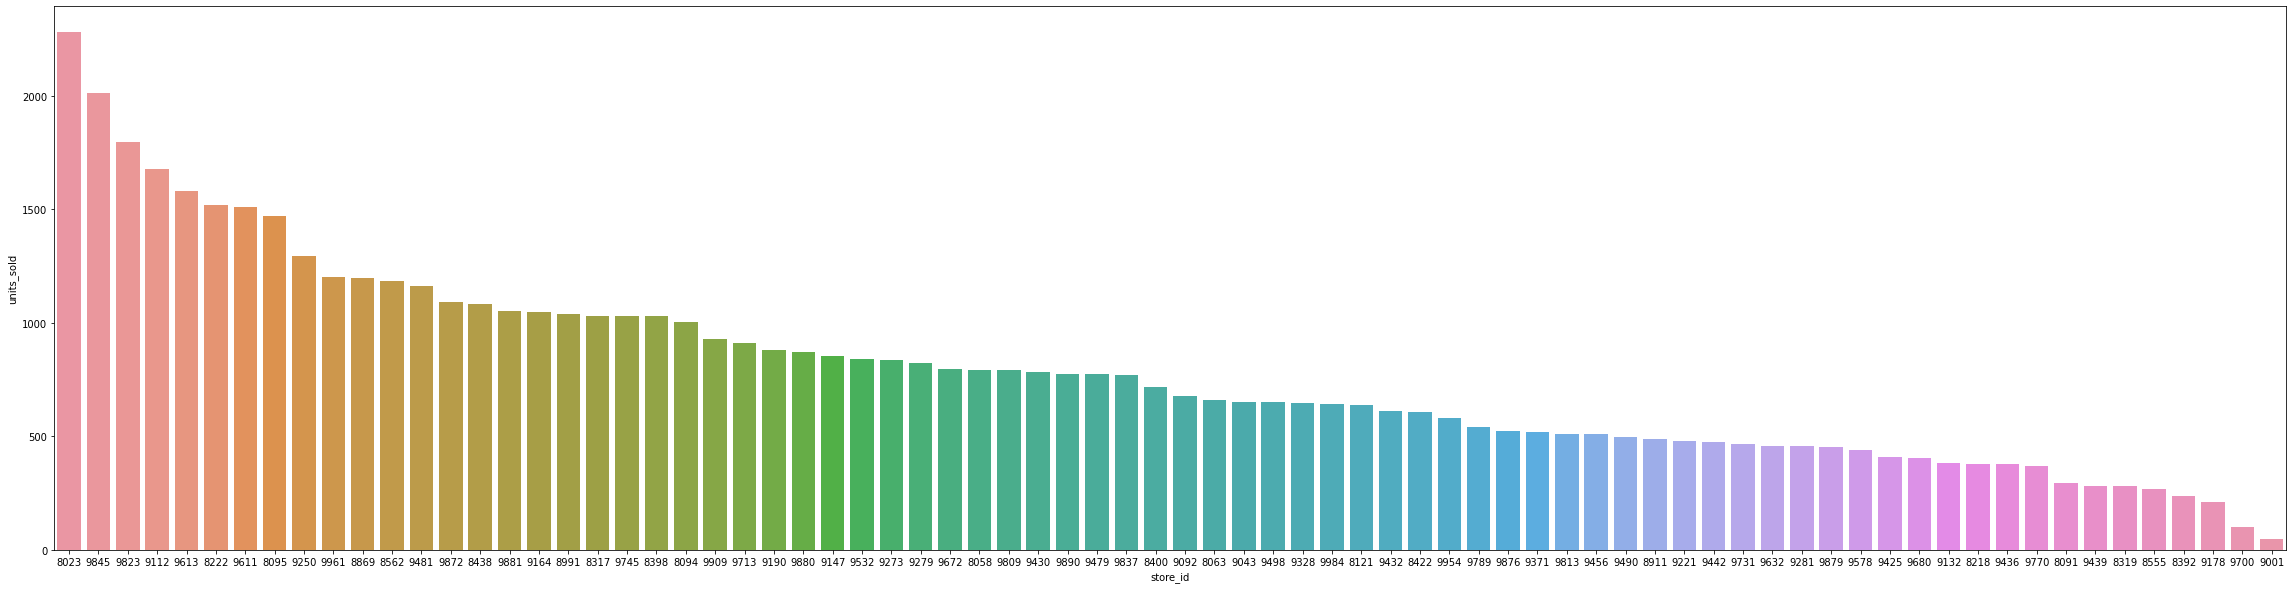

In [31]:
plt.rcParams['figure.figsize'] = (40,10)
sns.barplot(data =store_units_sold ,x ='store_id',y = 'units_sold',order = store_units_sold['store_id'])

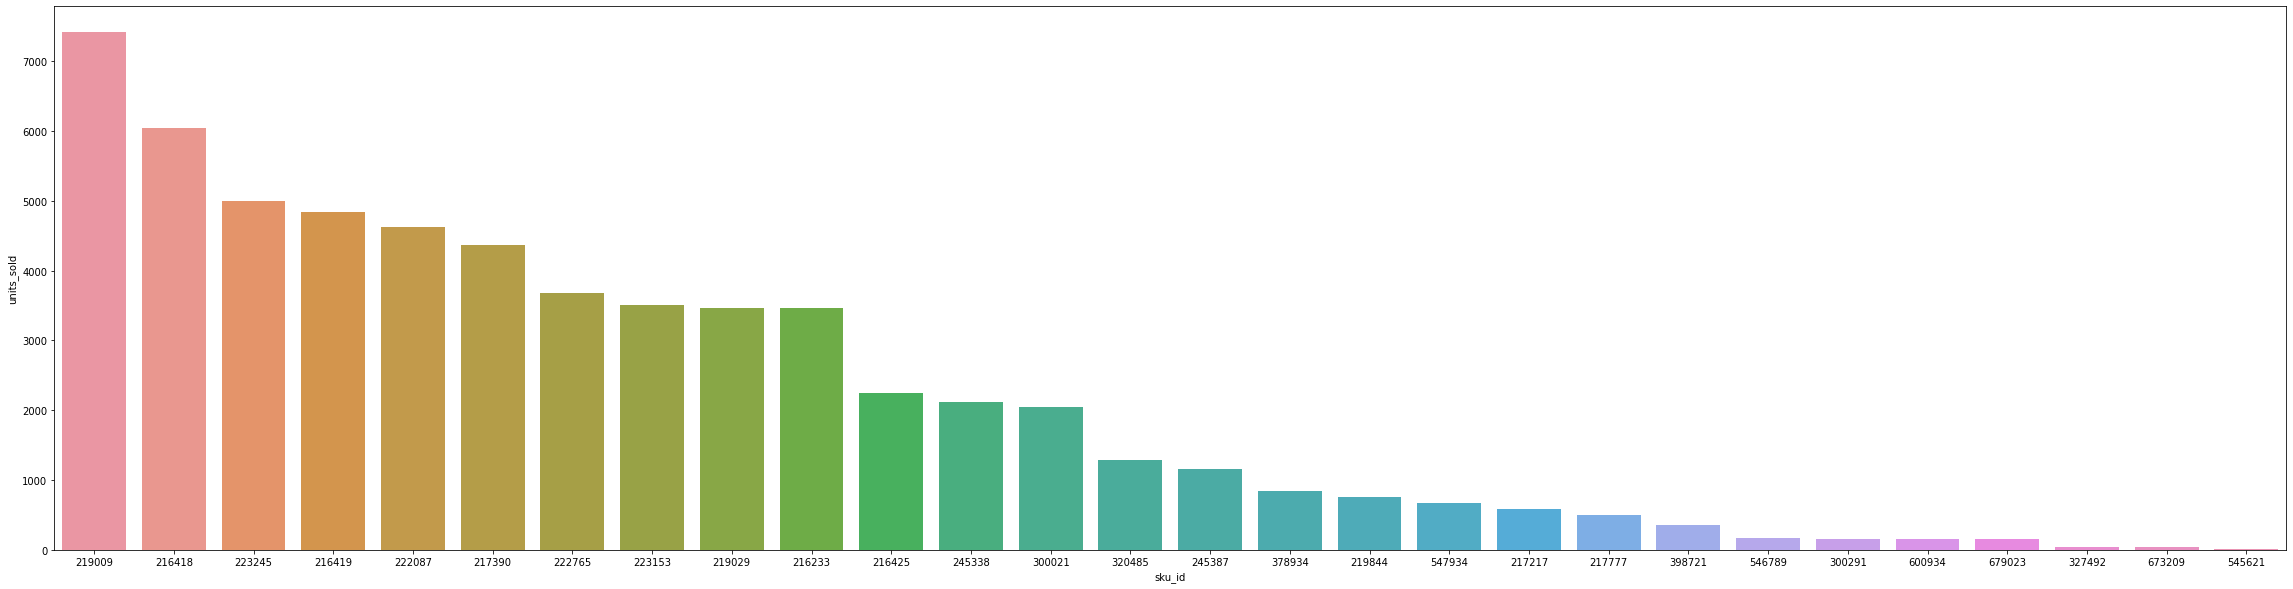

In [32]:
sns.barplot(x ='sku_id',y='units_sold',data = items_units_sold,order=items_units_sold['sku_id'])

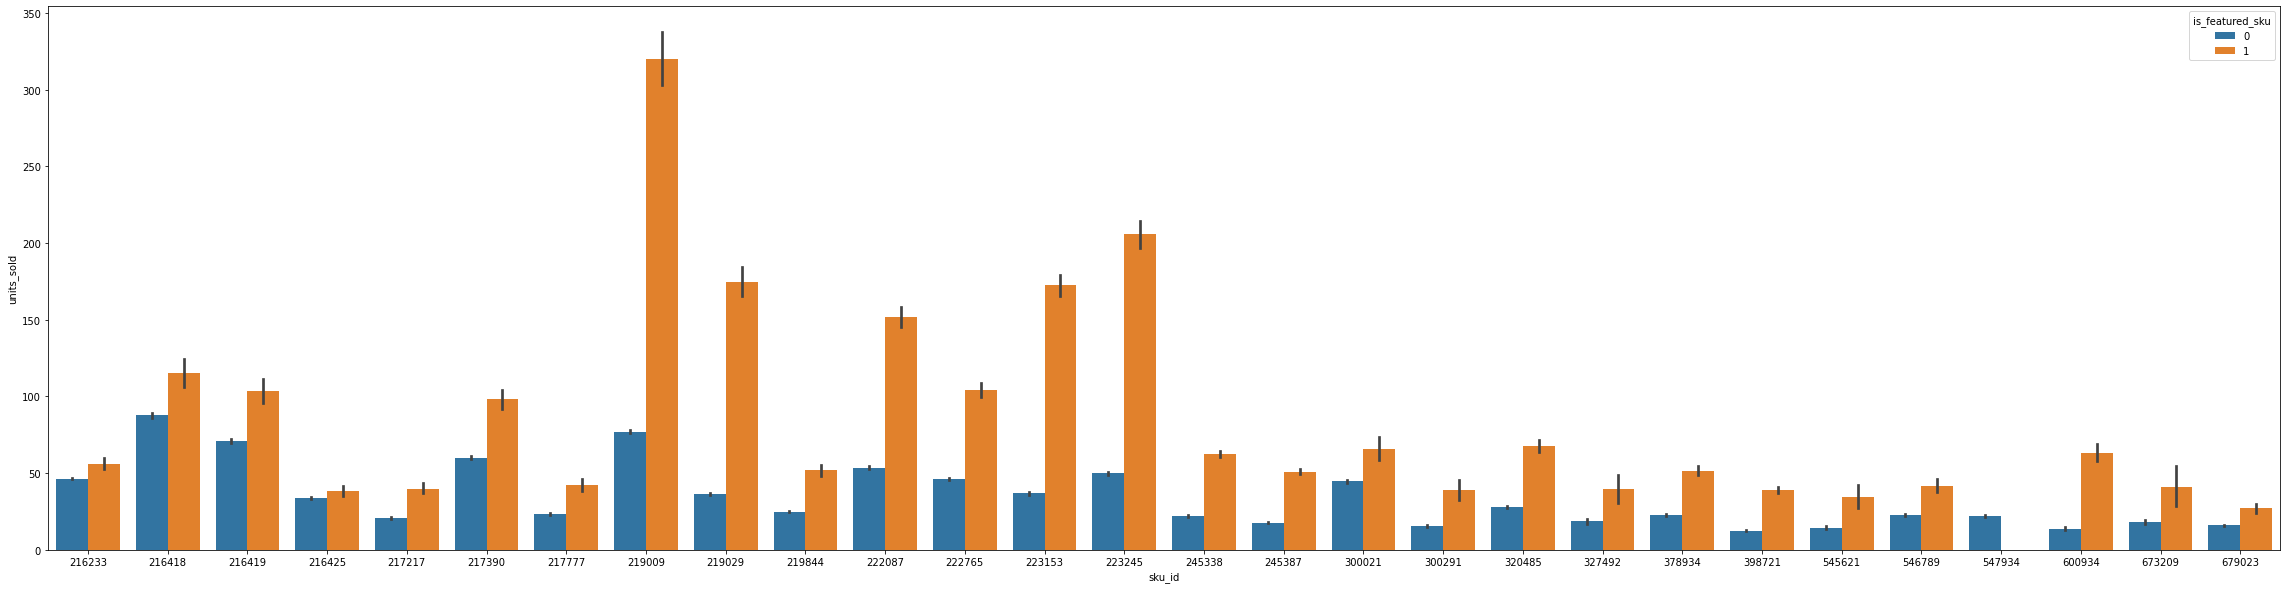

In [33]:
sns.barplot(x='sku_id',y='units_sold',hue='is_featured_sku',data = train_data,dodge=True)

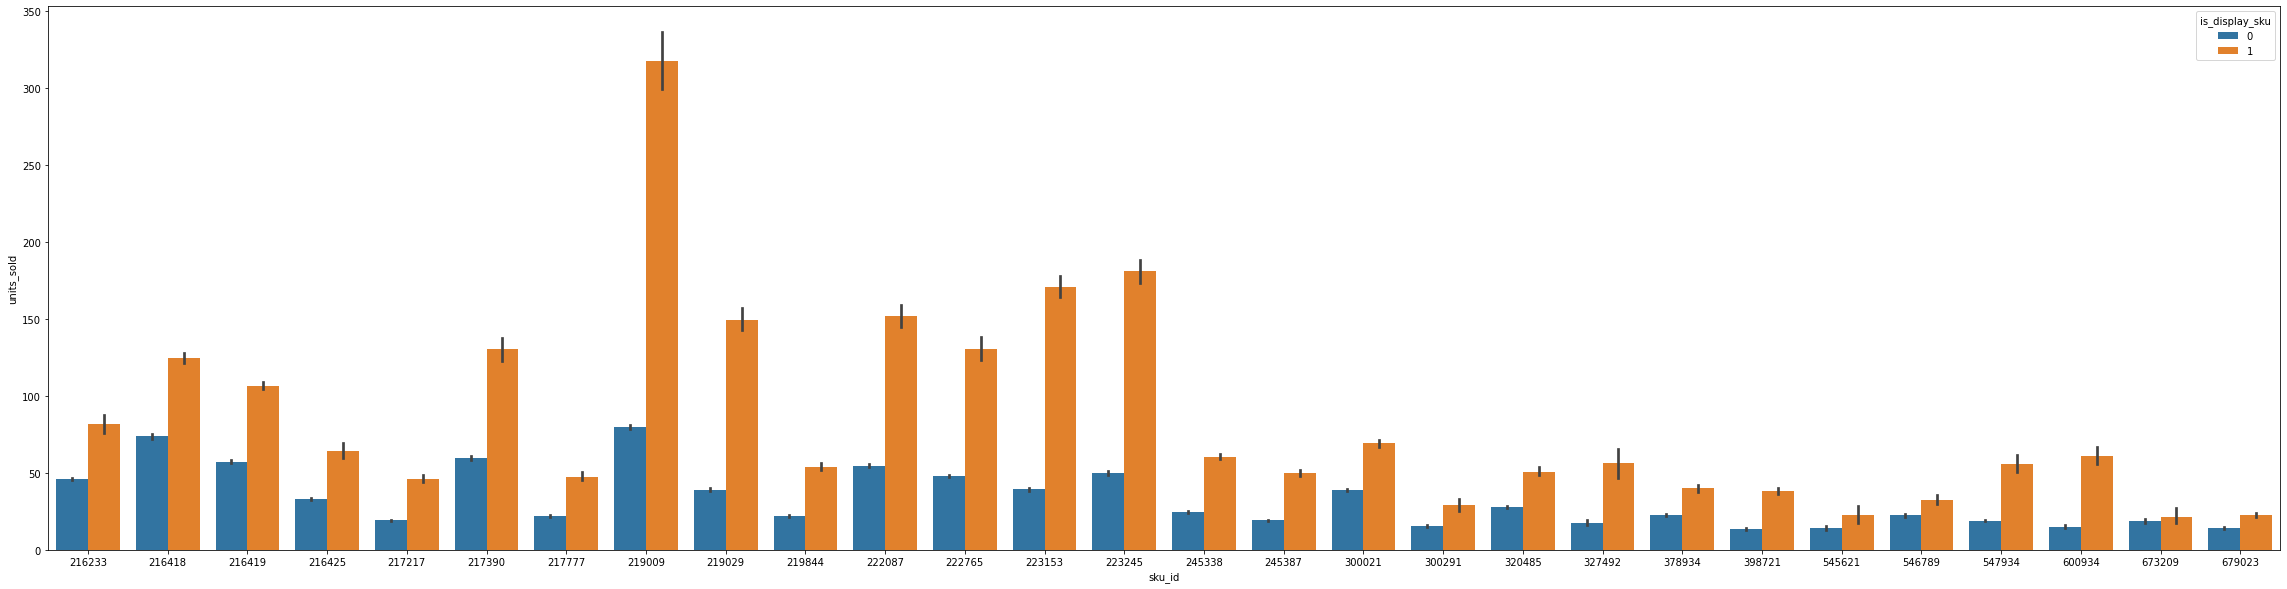

In [34]:
sns.barplot(x='sku_id',y='units_sold',hue='is_display_sku',data = train_data,dodge=True)

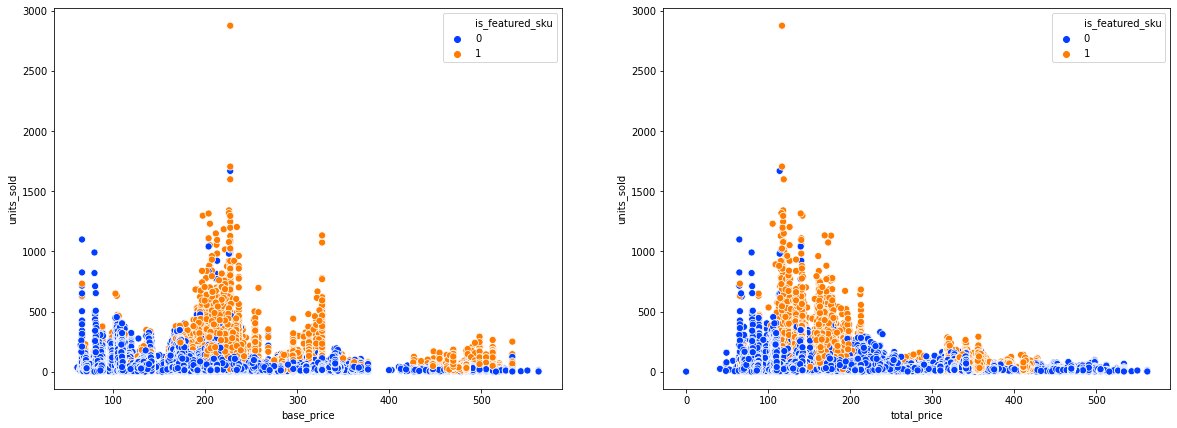

In [35]:
plt.rcParams['figure.figsize']=(20,7)
fig,axs = plt.subplots(1,2)
axs = axs.flatten()
sns.scatterplot(x= 'base_price',y='units_sold',hue='is_featured_sku',data=train_data,marker="o",alpha = 1,palette='bright',s=50,ax= axs[0])
sns.scatterplot(x= 'total_price',y='units_sold',hue='is_featured_sku',data=train_data,marker="o",alpha = 1,palette='bright',s=50,ax= axs[1])


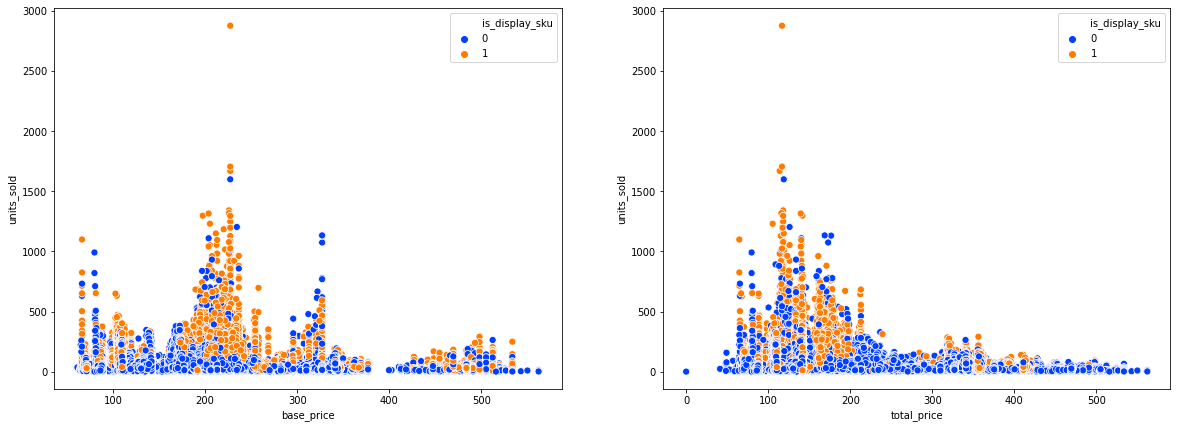

In [36]:
plt.rcParams['figure.figsize']=(20,7)
fig,axs = plt.subplots(1,2)
axs = axs.flatten()
sns.scatterplot(x= 'base_price',y='units_sold',hue='is_display_sku',data=train_data,marker="o",alpha = 1,palette='bright',s=50,ax= axs[0])
sns.scatterplot(x= 'total_price',y='units_sold',hue='is_display_sku',data=train_data,marker="o",alpha = 1,palette='bright',s=50,ax= axs[1])


In [37]:
data_wo_na = data_store_items_reshape.dropna(axis = 0,inplace = False)

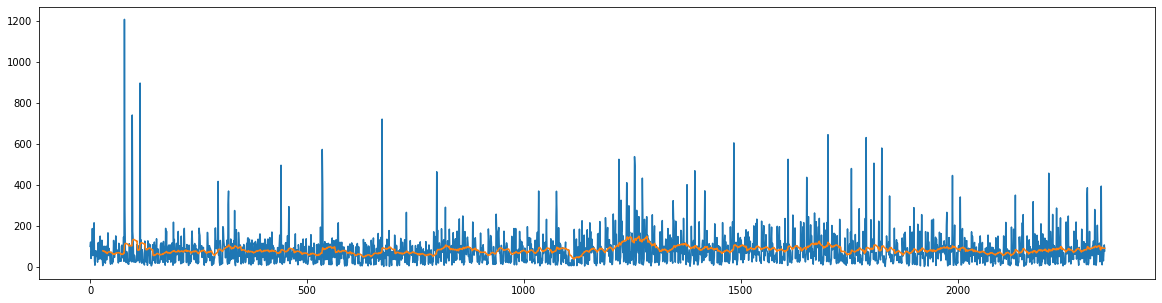

In [38]:
plt.rcParams['figure.figsize'] = (20,5)
plt.plot(train_data['units_sold'][(train_data['store_id'] == '8095')].values)
plt.plot(train_data['units_sold'][(train_data['store_id'] == '8095')].rolling(30).mean().values)

In [39]:
data_store_items.fillna(value = 0)
dt = (data_store_items.set_index('index',drop = True))

In [40]:
px.imshow(dt.values)

In [41]:
data_store_items_fillna = data_store_items_reshape.fillna(0)

In [42]:
store_ids = list(train_data['store_id'].unique())
item_ids = list(train_data['sku_id'].unique())
 

In [43]:
combo_item_store = train_data.groupby(['store_id','sku_id'])['units_sold'].count().values

In [44]:
combo_values = np.zeros((len(store_ids)*len(item_ids),np.max(combo_item_store)))

In [45]:
m = 0
for i in (store_ids):

  for j in (item_ids):

    if (train_data['units_sold'][(train_data['store_id'] == i)&(train_data['sku_id'] == j)]).empty == False:

      l = len((train_data['units_sold'][(train_data.store_id == i)&(train_data.sku_id == j)]))
      combo_values[m,:l] = (train_data['units_sold'][(train_data.store_id == i)&(train_data.sku_id == j)]).values.reshape(1,-1)


      m = m+1 

      if m == len(combo_values):

        break


In [46]:
combo_values = pd.DataFrame(combo_values)

In [47]:
combo_values.replace(to_replace = 0, value = np.nan,inplace = True)

In [48]:
combo_values.dropna()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129
0,20.0,34.0,10.0,17.0,24.0,29.0,16.0,14.0,20.0,18.0,27.0,20.0,7.0,14.0,39.0,7.0,31.0,37.0,28.0,19.0,14.0,33.0,19.0,17.0,6.0,18.0,23.0,34.0,12.0,15.0,23.0,13.0,22.0,26.0,32.0,19.0,21.0,18.0,30.0,33.0,...,25.0,24.0,19.0,12.0,27.0,29.0,23.0,15.0,11.0,17.0,26.0,22.0,45.0,25.0,24.0,24.0,33.0,17.0,28.0,19.0,14.0,7.0,28.0,17.0,6.0,7.0,17.0,20.0,13.0,17.0,10.0,12.0,25.0,34.0,12.0,11.0,25.0,4.0,9.0,10.0
1,28.0,14.0,27.0,8.0,9.0,18.0,20.0,20.0,21.0,29.0,21.0,17.0,30.0,22.0,10.0,18.0,30.0,35.0,12.0,27.0,18.0,24.0,25.0,17.0,25.0,11.0,17.0,13.0,27.0,8.0,29.0,32.0,25.0,29.0,48.0,32.0,22.0,21.0,29.0,27.0,...,26.0,44.0,27.0,34.0,13.0,25.0,39.0,31.0,27.0,36.0,40.0,32.0,35.0,33.0,21.0,40.0,31.0,16.0,22.0,22.0,20.0,9.0,14.0,13.0,26.0,18.0,15.0,19.0,12.0,13.0,12.0,9.0,27.0,9.0,26.0,10.0,35.0,37.0,22.0,18.0
2,19.0,17.0,27.0,18.0,23.0,12.0,33.0,2.0,49.0,27.0,43.0,18.0,24.0,25.0,9.0,20.0,49.0,36.0,31.0,31.0,33.0,58.0,53.0,27.0,17.0,22.0,36.0,15.0,20.0,21.0,46.0,31.0,24.0,19.0,32.0,60.0,13.0,7.0,10.0,25.0,...,18.0,43.0,23.0,21.0,9.0,46.0,9.0,22.0,13.0,29.0,32.0,21.0,11.0,36.0,43.0,33.0,37.0,28.0,47.0,48.0,52.0,18.0,36.0,21.0,26.0,20.0,31.0,50.0,23.0,18.0,35.0,50.0,6.0,28.0,23.0,50.0,52.0,35.0,27.0,22.0
3,44.0,28.0,18.0,36.0,40.0,33.0,40.0,38.0,48.0,50.0,53.0,22.0,21.0,16.0,27.0,19.0,37.0,42.0,24.0,48.0,22.0,63.0,43.0,13.0,29.0,28.0,39.0,20.0,29.0,26.0,43.0,38.0,34.0,25.0,43.0,41.0,18.0,12.0,33.0,24.0,...,37.0,26.0,17.0,18.0,23.0,40.0,6.0,28.0,18.0,27.0,15.0,32.0,16.0,12.0,45.0,14.0,21.0,27.0,33.0,17.0,36.0,29.0,58.0,39.0,21.0,23.0,23.0,28.0,34.0,23.0,11.0,44.0,35.0,25.0,18.0,45.0,34.0,20.0,27.0,38.0
4,52.0,51.0,42.0,56.0,58.0,21.0,24.0,21.0,32.0,26.0,21.0,30.0,30.0,39.0,22.0,23.0,33.0,19.0,22.0,12.0,22.0,32.0,19.0,52.0,56.0,45.0,42.0,37.0,24.0,12.0,41.0,34.0,26.0,17.0,17.0,7.0,29.0,29.0,29.0,24.0,...,36.0,23.0,26.0,32.0,19.0,30.0,15.0,14.0,18.0,23.0,27.0,14.0,11.0,25.0,17.0,27.0,21.0,25.0,23.0,22.0,12.0,18.0,32.0,24.0,24.0,24.0,53.0,39.0,44.0,43.0,21.0,21.0,17.0,48.0,59.0,40.0,57.0,11.0,23.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,29.0,27.0,26.0,26.0,28.0,29.0,26.0,35.0,19.0,19.0,40.0,28.0,25.0,20.0,28.0,23.0,18.0,12.0,19.0,19.0,29.0,15.0,11.0,16.0,15.0,17.0,28.0,23.0,22.0,12.0,17.0,12.0,26.0,20.0,20.0,24.0,27.0,20.0,21.0,24.0,...,24.0,21.0,24.0,20.0,30.0,25.0,42.0,21.0,29.0,16.0,34.0,20.0,24.0,23.0,13.0,20.0,35.0,50.0,89.0,36.0,14.0,26.0,39.0,34.0,38.0,42.0,50.0,33.0,27.0,35.0,15.0,28.0,40.0,39.0,33.0,25.0,20.0,15.0,9.0,12.0
1151,17.0,17.0,47.0,39.0,40.0,19.0,28.0,36.0,31.0,67.0,75.0,33.0,21.0,21.0,17.0,22.0,27.0,240.0,26.0,22.0,31.0,25.0,14.0,26.0,41.0,17.0,33.0,63.0,45.0,24.0,31.0,49.0,40.0,16.0,11.0,27.0,39.0,40.0,24.0,29.0,...,25.0,24.0,27.0,59.0,38.0,39.0,34.0,54.0,56.0,39.0,17.0,23.0,18.0,21.0,16.0,13.0,29.0,24.0,35.0,65.0,84.0,73.0,33.0,29.0,39.0,46.0,41.0,34.0,28.0,23.0,37.0,42.0,56.0,47.0,29.0,41.0,44.0,120.0,125.0,23.0
1152,22.0,19.0,12.0,11.0,8.0,7.0,11.0,11.0,10.0,11.0,13.0,15.0,16.0,13.0,17.0,12.0,7.0,19.0,9.0,22.0,15.0,13.0,14.0,19.0,14.0,22.0,39.0,15.0,10.0,17.0,18.0,18.0,7.0,10.0,10.0,15.0,73.0,51.0,34.0,38.0,...,26.0,53.0,73.0,16.0,7.0,7.0,9.0,23.0,22.0,12.0,12.0,18.0,16.0,21.0,10.0,16.0,16.0,75.0,136.0,18.0,19.0,17.0,65.0,63.0,41.0,26.0,38.0,4.0,23.0,12.0,33.0,10.0,20.0,20.0,16.0,29.0,27.0,19.0,19.0,31.0
1153,7.0,7.0,17.0,14.0,15.0,16.0,12.0,1.0,11.0,16.0,8.0,7.0,17.0,8.0,23.0,20.0,18.0,15.0,21.0,9.0,16.0,13.0,7.0,10.0,7.0,13.0,14.0,6.0,8.0,9.0,12.0,10.0,7.0,15.0,8.0,4.0,14.0,5.0

In [49]:
train_data

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year,month,week_num
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,2011,1,3
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,2011,1,3
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,2011,1,3
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,2011,1,3
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,2011,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-07-09,9984,223245,235.8375,235.8375,0,0,38,2013,7,28
150146,212639,2013-07-09,9984,223153,235.8375,235.8375,0,0,30,2013,7,28
150147,212642,2013-07-09,9984,245338,357.6750,483.7875,1,1,31,2013,7,28
150148,212643,2013-07-09,9984,547934,141.7875,191.6625,0,1,12,2013,7,28


In [66]:
train_data_new = train_data.drop(['store_id','sku_id'],axis = 1,inplace=False)
train_data_new['discounts'] = train_data['base_price'] - train_data['total_price']
train_data_new.drop(['base_price','total_price'],axis = 1,inplace =True)

In [67]:
train_data_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150150 entries, 2011-01-17 to 2013-07-09
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   record_ID        150150 non-null  int64         
 1   week             150150 non-null  datetime64[ns]
 2   is_featured_sku  150150 non-null  int64         
 3   is_display_sku   150150 non-null  int64         
 4   units_sold       150150 non-null  int64         
 5   year             150150 non-null  int64         
 6   month            150150 non-null  int64         
 7   week_num         150150 non-null  int64         
 8   discounts        150150 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 11.5 MB


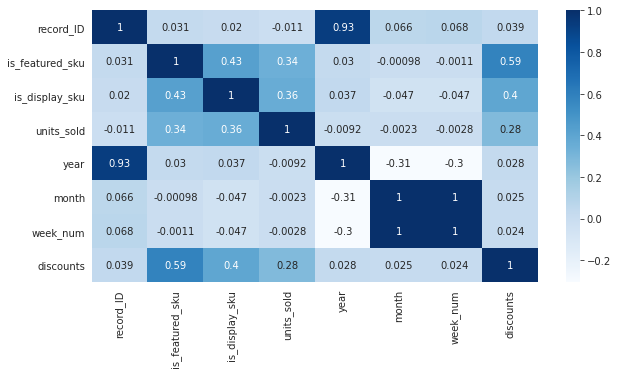

In [68]:
plt.rcParams['figure.figsize'] = (10,5)
sns.heatmap(train_data_new.corr(), annot=True,cmap = 'Blues')

In [53]:
train_data.set_index('week',drop = False,inplace = True)

In [54]:
train_data.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year,month,week_num
week,,,,,,,,,,,,
2011-01-17,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,2011,1,3
2011-01-17,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,2011,1,3
2011-01-17,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,2011,1,3
2011-01-17,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,2011,1,3
2011-01-17,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,2011,1,3


In [62]:

for i in range(20):
  if i == 0:
    df1 = train_data[train_data['store_id'] == store_ids[i]].rolling(30).mean().reset_index()

  else:

    df2 = train_data[train_data['store_id'] == store_ids[i]].rolling(30).mean().reset_index()

    df1 = pd.concat((df1,df2),axis = 0)
    df1.dropna(axis = 0,inplace = True)


In [63]:
px.line(data_frame = df1,y = 'units_sold',color = 'store_id',)


In [64]:
sns.set_style('white')
fig = px.line_3d(data_frame = df1, z = 'units_sold',y = 'store_id',color = 'store_id',x = 'week',height= 600,width = 1000)
fig.show()

In [69]:
train_data_new.set_index('record_ID',drop = True,inplace=True)

In [174]:
data_ =  train_data_new[['week_num','month','year','is_featured_sku','is_display_sku','discounts','units_sold']]

In [175]:
data_.columns = ['week_id','month','day','featured','displayed','discounts','units_sold']

In [176]:
data_.head()

,week_id,month,day,featured,displayed,discounts,units_sold
record_ID,,,,,,,
1,3,1,2011,0,0,12.825,20
2,3,1,2011,0,0,0.000,28
3,3,1,2011,0,0,0.000,19
4,3,1,2011,0,0,0.000,44
5,3,1,2011,0,0,0.000,52


In [188]:
n_t  = 12 #10 weeks as timesteps
n_o = 1
f = len(data_.columns)  # no of attributes used for prediction 

In [189]:
def to_supervised(X,n_t,n_o,f):
    
    names = list()
    cols = list()

    for j in range(f):
    
        for k in range(n_t,0,-1):
            
            col = X[X.columns[j]].shift(k)
            cols.append(col)
            names +=[(X.columns[j]+'(t'+str('%+d')+')') %-k]
            
    
        
    for j in range(f):
        
        for k in range(0,n_o):
       
        
            
        
            if k == 0:
                col = X[X.columns[j]].shift(k)
                cols.append(col)
                names+= [(X.columns[j]+'(t)')]
             
            else:
                col = X[X.columns[j]].shift(k)
                cols.append(col)
                names +=[(X.columns[j]+'(t'+str('%+d')+')') %k]
                
    
    
    
    Dataset = pd.concat(cols,axis =1)
    Dataset.columns = names            
    Dataset.dropna(inplace = True)  
    
    
    
    return names,Dataset   

In [190]:
names, Dataset = to_supervised(data_,n_t,n_o,f)

In [191]:
Dataset.head()

,week_id(t-12),week_id(t-11),week_id(t-10),week_id(t-9),week_id(t-8),week_id(t-7),week_id(t-6),week_id(t-5),week_id(t-4),week_id(t-3),week_id(t-2),week_id(t-1),month(t-12),month(t-11),month(t-10),month(t-9),month(t-8),month(t-7),month(t-6),month(t-5),month(t-4),month(t-3),month(t-2),month(t-1),day(t-12),day(t-11),day(t-10),day(t-9),day(t-8),day(t-7),day(t-6),day(t-5),day(t-4),day(t-3),day(t-2),day(t-1),featured(t-12),featured(t-11),featured(t-10),featured(t-9),...,displayed(t-9),displayed(t-8),displayed(t-7),displayed(t-6),displayed(t-5),displayed(t-4),displayed(t-3),displayed(t-2),displayed(t-1),discounts(t-12),discounts(t-11),discounts(t-10),discounts(t-9),discounts(t-8),discounts(t-7),discounts(t-6),discounts(t-5),discounts(t-4),discounts(t-3),discounts(t-2),discounts(t-1),units_sold(t-12),units_sold(t-11),units_sold(t-10),units_sold(t-9),units_sold(t-8),units_sold(t-7),units_sold(t-6),units_sold(t-5),units_sold(t-4),units_sold(t-3),units_sold(t-2),units_sold(t-1),week_id(t),month(t),day(t),featured(t),displayed(t),discounts(t),units_sold(t)
record_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.825,0.0,0.0,0.0,0.000,0.000,0.000,0.000,44.175,0.0,0.0,0.0000,20.0,28.0,19.0,44.0,52.0,18.0,47.0,50.0,82.0,99.0,120.0,40.0,3,1,2011,0,0,0.0000,68
23,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000,44.175,0.000,0.0,0.0,0.0000,28.0,19.0,44.0,52.0,18.0,47.0,50.0,82.0,99.0,120.0,40.0,68.0,3,1,2011,0,0,0.0000,87
24,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,44.175,0.000,0.000,0.0,0.0,0.0000,19.0,44.0,52.0,18.0,47.0,50.0,82.0,99.0,120.0,40.0,68.0,87.0,3,1,2011,0,0,0.0000,186
27,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,44.175,0.000,0.000,0.000,0.0,0.0,0.0000,44.0,52.0,18.0,47.0,50.0,82.0,99.0,120.0,40.0,68.0,87.0,186.0,3,1,2011,0,0,43.4625,54
28,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,44.175,0.000,0.000,0.000,0.000,0.0,0.0,43.4625,52.0,18.0,47.0,50.0,82.0,99.0,120.0,40.0,68.0,87.0,186.0,54.0,3,1,2011,0,0,0.0000,74


In [181]:
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler() 



In [140]:
#def create_dataset(X, y, time_steps=1):
#    Xs, ys = [], []
#    for i in range(len(X) - time_steps):
#        v = X.iloc[i:(i + time_steps)].values
#        Xs.append(v)        
#        ys.append(y.iloc[i + time_steps])
#    return np.array(Xs), np.array(ys)

In [192]:
X_input = Dataset[Dataset.columns[:n_t*f]]

In [193]:
X_input.head()

,week_id(t-12),week_id(t-11),week_id(t-10),week_id(t-9),week_id(t-8),week_id(t-7),week_id(t-6),week_id(t-5),week_id(t-4),week_id(t-3),week_id(t-2),week_id(t-1),month(t-12),month(t-11),month(t-10),month(t-9),month(t-8),month(t-7),month(t-6),month(t-5),month(t-4),month(t-3),month(t-2),month(t-1),day(t-12),day(t-11),day(t-10),day(t-9),day(t-8),day(t-7),day(t-6),day(t-5),day(t-4),day(t-3),day(t-2),day(t-1),featured(t-12),featured(t-11),featured(t-10),featured(t-9),...,featured(t-4),featured(t-3),featured(t-2),featured(t-1),displayed(t-12),displayed(t-11),displayed(t-10),displayed(t-9),displayed(t-8),displayed(t-7),displayed(t-6),displayed(t-5),displayed(t-4),displayed(t-3),displayed(t-2),displayed(t-1),discounts(t-12),discounts(t-11),discounts(t-10),discounts(t-9),discounts(t-8),discounts(t-7),discounts(t-6),discounts(t-5),discounts(t-4),discounts(t-3),discounts(t-2),discounts(t-1),units_sold(t-12),units_sold(t-11),units_sold(t-10),units_sold(t-9),units_sold(t-8),units_sold(t-7),units_sold(t-6),units_sold(t-5),units_sold(t-4),units_sold(t-3),units_sold(t-2),units_sold(t-1)
record_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.825,0.0,0.0,0.0,0.000,0.000,0.000,0.000,44.175,0.0,0.0,0.0000,20.0,28.0,19.0,44.0,52.0,18.0,47.0,50.0,82.0,99.0,120.0,40.0
23,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000,44.175,0.000,0.0,0.0,0.0000,28.0,19.0,44.0,52.0,18.0,47.0,50.0,82.0,99.0,120.0,40.0,68.0
24,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,44.175,0.000,0.000,0.0,0.0,0.0000,19.0,44.0,52.0,18.0,47.0,50.0,82.0,99.0,120.0,40.0,68.0,87.0
27,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,44.175,0.000,0.000,0.000,0.0,0.0,0.0000,44.0,52.0,18.0,47.0,50.0,82.0,99.0,120.0,40.0,68.0,87.0,186.0
28,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,44.175,0.000,0.000,0.000,0.000,0.0,0.0,43.4625,52.0,18.0,47.0,50.0,82.0,99.0,120.0,40.0,68.0,87.0,186.0,54.0


In [194]:
target = Dataset[Dataset.columns[-n_o:]]

In [195]:
target.head()

,units_sold(t)
record_ID,
22,68
23,87
24,186
27,54
28,74


In [196]:
X_train,X_val,Y_train,Y_val = train_test_split(X_input,target,random_state = 42, shuffle = False,test_size = 0.20)

In [197]:
print('size of train dataset:', X_train.shape)
print('size of validation dataset:', X_val.shape)
print('size of target train:', Y_train.shape)

size of train dataset: (120110, 84)
size of validation dataset: (30028, 84)
size of target train: (120110, 1)


In [198]:
# normalize the dataset 

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
Y_train_scaled = scaler.fit_transform(Y_train)
Y_val_scaled = scaler.fit_transform(Y_val)

In [199]:
# reshape the data to fit for LSTM training

def reshape_train_test(X1,X2,n_o):
    X11 = X1.reshape(X1.shape[0],n_o,X1.shape[1])
    X22 = X2.reshape(X2.shape[0],n_o,X1.shape[1])
    
    return X11,X22

X_train_LSTM,X_val_LSTM = reshape_train_test(X_train_scaled,X_val_scaled,n_o)

In [200]:
from keras.models import Sequential
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,ZeroPadding2D,add,BatchNormalization,Activation,AveragePooling2D,Dropout
from keras.layers import LSTM,Bidirectional
from keras.datasets import mnist
from keras.utils import to_categorical,plot_model
from keras.optimizers import SGD,Adam

from keras.models import load_model,Model
from keras.backend import placeholder
from keras.initializers import glorot_uniform
from keras.utils import multi_gpu_model
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [201]:
def LSTM_model(X1):
  
  X_i = Input(shape = (X1.shape[1],X1.shape[2]))
  
  X = Bidirectional(LSTM(256,activation = 'relu',kernel_initializer= 'glorot_uniform',input_shape = (X1.shape[1:]),name = 'layer1'))(X_i)
  X = Dropout(0.2)(X)
  X = Dense(1,activation = 'linear',name = 'layer3')(X)

  model = Model(inputs = X_i,outputs = X)

  return model



model = LSTM_model(X_train_LSTM)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 1, 84)             0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 512)               698368    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
layer3 (Dense)               (None, 1)                 513       
Total params: 698,881
Trainable params: 698,881
Non-trainable params: 0
_________________________________________________________________


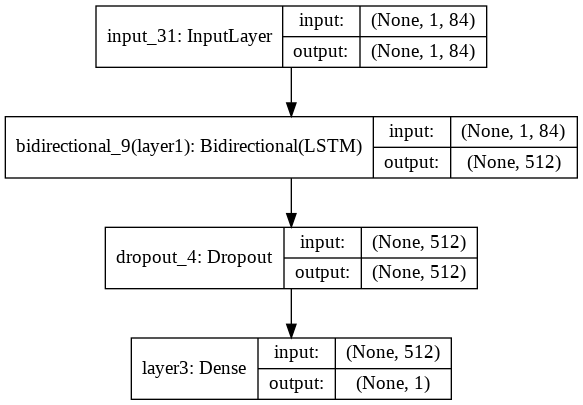

In [202]:
model.summary()
plot_model(model, show_shapes=True, to_file='/content/Demand-Forecasting/LSTM_demandforecasting.png')


Train on 120110 samples, validate on 30028 samples
Epoch 1/20
120110/120110 [==============================] - 25s 207us/step - loss: 4.7521e-04 - root_mean_squared_error: 0.0218 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 2/20
120110/120110 [==============================] - 24s 203us/step - loss: 4.7516e-04 - root_mean_squared_error: 0.0218 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753
Epoch 3/20
120110/120110 [==============================] - 24s 202us/step - loss: 4.7537e-04 - root_mean_squared_error: 0.0218 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1872
Epoch 4/20
120110/120110 [==============================] - 25s 209us/step - loss: 4.7186e-04 - root_mean_squared_error: 0.0217 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1686
Epoch 5/20
120110/120110 [==============================] - 25s 204us/step - loss: 4.7658e-04 - root_mean_squared_error: 0.0218 - val_loss: 0.0509 - val_root_mean_squared_error: 0.2256
Epoch 6/20
120110/120110

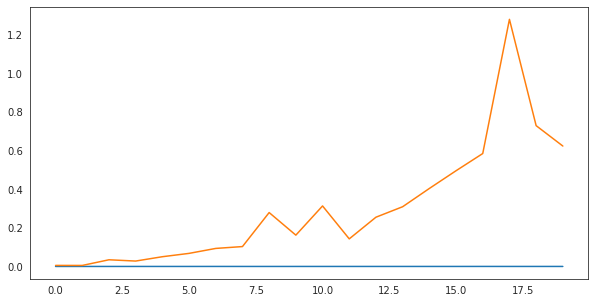

In [204]:
model.compile(optimizer = Adam(lr=0.01),loss = 'mse',metrics = [RootMeanSquaredError()])
history = model.fit(X_train_LSTM,Y_train_scaled,batch_size = 32, epochs = 20,validation_data = (X_val_LSTM,Y_val_scaled))
plt.plot(history.history['loss'],label ='train')
plt.plot(history.history['val_loss'],label = 'val loss')

In [205]:
results = model.evaluate(X_train_LSTM, Y_train_scaled, batch_size=128)
pred_train = model.predict(X_train_LSTM) 

120110/120110 [==============================] - 1s 12us/step


In [207]:
pred = scaler.inverse_transform(pred_train)

In [208]:
print(pred.shape)
print(Y_train.shape)

(120110, 1)
(120110, 1)


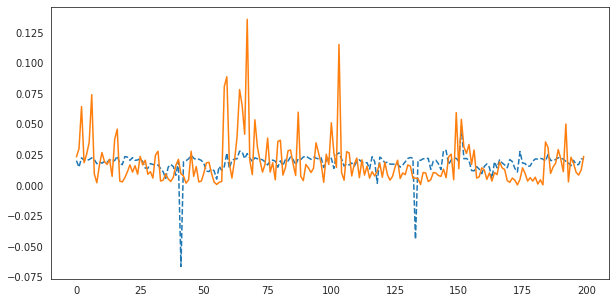

In [209]:
plt.plot(pred_train[0:200,-1],'--')
plt.plot(Y_train_scaled[0:200,-1])

In [140]:
pred_train

array([[0.01772534, 0.01646615, 0.02097212, ..., 0.01582534, 0.01598519,
        0.0135036 ],
       [0.01946978, 0.02786694, 0.01886546, ..., 0.02637447, 0.0164217 ,
        0.01119533],
       [0.0172678 , 0.02130231, 0.02818633, ..., 0.01331956, 0.02985925,
        0.01615976],
       ...,
       [0.0135868 , 0.01011004, 0.011705  , ..., 0.00864515, 0.01020223,
        0.01108121],
       [0.01356388, 0.01074071, 0.00743738, ..., 0.00883208, 0.00820754,
        0.01166952],
       [0.01305912, 0.0105619 , 0.00895098, ..., 0.0081043 , 0.00908585,
        0.01046965]], dtype=float32)